<a href="https://colab.research.google.com/github/Bhuvana908/ML-Projects/blob/main/Sentiment%20Analysis%20on%20Product%20Reviews%20using%20NLP%20%26%20KNN/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
# Display matplotlib plots directly inside Jupyter/Colab notebooks
import sqlite3 # Work with SQLite database files
import pandas as pd
import numpy as np
import nltk # Natural language processing toolkit
import matplotlib.pyplot as plt
import seaborn as sns # Advanced statistical data visualization
from sklearn.feature_extraction.text import TfidfTransformer # Convert counts to TF-IDF weights
from sklearn.feature_extraction.text import TfidfVectorizer # Transform text into TF-IDF vectors
from sklearn.feature_extraction.text import CountVectorizer # Convert text into token count matrix
from sklearn.metrics import confusion_matrix # Generate confusion matrix for evaluation
from sklearn import metrics
from sklearn.metrics import roc_curve, auc # Plot ROC curve and compute AUC score
from nltk.stem.porter import PorterStemmer # Stem words to their root form

from google.colab import files
uploaded = files.upload()

#Using the SQLite Table to read data
con=sqlite3.connect('database.sqlite')

Saving database.sqlite to database (1).sqlite


In [ ]:
con = sqlite3.connect("database.sqlite")
cursor = con.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())


[('Reviews',)]


In [ ]:
filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con)

def partition(x):
  if x<3:
    return 'negative'
  return 'positive'

actualScore=filtered_data['Score']
positiveNegative=actualScore.map(partition)
filtered_data['Score']=positiveNegative
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
display=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 AND UserId="AR5J8UI46CURR" ORDER BY ProductID""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [ ]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True)
final=sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)
final.shape


(364173, 10)

In [ ]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100  #To see how much % of data still remains

69.25890143662969

In [ ]:
display=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 AND Id=44737 OR Id=64422 ORDER BY ProductId""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)
final['Score'].value_counts()

(364171, 10)


,count
Score,
positive,307061
negative,57110


# BoW (Bag of words)

In [ ]:
count_vect=CountVectorizer()
final_counts=count_vect.fit_transform(final['Text'].values)


In [ ]:
final_counts.get_shape()

(364171, 115281)

# Text Preprocessing

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
print(stop)

{"mustn't", 'too', 'which', "aren't", 'couldn', "he's", 'this', 'how', 'are', 'doing', 'under', 'm', 'up', 'that', 'more', 'where', "didn't", 't', "they're", 'me', 'during', "we've", 'mightn', 'here', 'ours', 'such', 'a', 'your', "he'd", 'most', 'was', 'they', 'who', 'been', 'he', "we're", 'didn', 'below', 'by', 'as', 'or', 'before', 'itself', 'down', 'for', 'an', 'yours', 'did', "she'd", 'd', 've', 'does', 'y', 'am', 'off', 'while', 'against', 'being', 'shan', 'what', 'through', 's', "that'll", 'ourselves', 'll', 'needn', 'in', "haven't", 'having', 'himself', 'yourself', 'from', 'were', "he'll", "won't", 'so', 'same', 'both', "should've", 'of', 'those', 'the', 'after', 'its', 'have', 'mustn', 'very', 'further', 'other', 're', 'our', 'themselves', "it'd", "we'll", "you'd", 'why', "you're", 'herself', 'has', "they'll", 'his', 'her', 'when', 'aren', 'few', 'can', 'and', 'my', 'now', 'into', 'whom', 'hadn', 'weren', 'all', 'him', 'no', "i'd", 'haven', "couldn't", "shan't", "needn't", 'aga

In [ ]:
import re
import string
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

sno=nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr, ' ', sentence)
  return cleantext

def cleanpunc(sentence):
  cleaned=re.sub(r'[?|!|\'|"|#]', r'', sentence)
  cleaned=re.sub(r'[.|,|)|(|\|/]', r'', cleaned)
  return cleaned

print(sno.stem('tasty'))

tasti


In [ ]:
i = 0
str1 = ' '
final_string = []

all_positive_words = []   # Stores words from positive reviews
all_negative_words = []   # Stores words from negative reviews
s = ''

# Loop through each review text
for sent in final['Text'].values:

    filtered_sentence = []   # Stores cleaned words of one review

    # Remove HTML tags from the review
    sent = cleanhtml(sent)

    # Split sentence into words
    for w in sent.split():

        # Remove punctuation from each word
        for cleaned_words in cleanpunc(w).split():

            # Keep only alphabetic words with length > 2
            if cleaned_words.isalpha() and len(cleaned_words) > 2:

                # Remove stopwords
                if cleaned_words.lower() not in stop:

                    # Apply stemming to the word
                    s = sno.stem(cleaned_words.lower()).encode('utf8')

                    # Add word to cleaned sentence
                    filtered_sentence.append(s)

                    # Store words based on review sentiment
                    if final['Score'].values[i] == 'positive':
                        all_positive_words.append(s)
                    if final['Score'].values[i] == 'negative':
                        all_negative_words.append(s)
            else:
                continue

    # Join all cleaned words of the review into a single string
    str1 = b" ".join(filtered_sentence)

    # Store the cleaned review
    final_string.append(str1)

    # Move to the next review
    i += 1


In [ ]:
final['CleanedText']=final_string

In [ ]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [ ]:
conn=sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory=str
final.to_sql('Reviews', conn, schema=None, if_exists='replace')

364171

In [ ]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words: ", freq_dist_positive.most_common(20))
print("Most Common Negative Words: ", freq_dist_negative.most_common(20))

Most Common Positive Words:  [(b'like', 139072), (b'tast', 128077), (b'good', 112017), (b'flavor', 108653), (b'love', 107018), (b'use', 103603), (b'great', 103095), (b'one', 96537), (b'product', 90273), (b'tri', 86411), (b'tea', 83290), (b'coffe', 77985), (b'make', 74914), (b'get', 72029), (b'food', 64244), (b'would', 55457), (b'time', 54848), (b'buy', 54031), (b'realli', 52611), (b'eat', 51790)]
Most Common Negative Words:  [(b'tast', 34300), (b'like', 32225), (b'product', 28003), (b'one', 20521), (b'flavor', 19368), (b'would', 17947), (b'tri', 17691), (b'use', 15263), (b'good', 14908), (b'coffe', 14579), (b'get', 13770), (b'buy', 13711), (b'order', 12832), (b'food', 12643), (b'dont', 11808), (b'tea', 11574), (b'even', 11042), (b'box', 10734), (b'make', 9823), (b'time', 9720)]


# N-grams

In [ ]:
count_vect=CountVectorizer(ngram_range=(1,2) )
final_bigram_counts=count_vect.fit_transform(final['Text'].values)

In [ ]:
final_bigram_counts.get_shape()

(364171, 2910192)

# TF-IDF

In [ ]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
final_tf_idf=tf_idf_vect.fit_transform(final['Text'].values)

In [ ]:
final_tf_idf.get_shape()

(364171, 2910192)

In [ ]:
features=tf_idf_vect.get_feature_names_out()
len(features)

2910192

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    # Get indices of words sorted by TF-IDF score (highest to lowest)
    topn_ids = np.argsort(row)[::-1][:top_n]

    # Pair each top word with its corresponding TF-IDF value
    top_feats = [(features[i], row[i]) for i in topn_ids]

    # Convert the word–TF-IDF pairs into a DataFrame
    df = pd.DataFrame(top_feats, columns=['feature', 'tfidf'])

    # Return the DataFrame containing top TF-IDF features
    return df


# Extract top 25 important words from the second review
top_tfidf = top_tfidf_feats(
    final_tf_idf[1, :].toarray()[0],  # TF-IDF scores of one review
    features,                        # List of all vocabulary words
    25                               # Number of top words to display
)

# Display the result
top_tfidf


,feature,tfidf
0,the paperbacks,0.173437
1,these sendak,0.173437
2,paperbacks seem,0.173437
3,sendak books,0.173437
4,rosie movie,0.173437
5,cover version,0.173437
6,pages open,0.173437
7,paperbacks,0.168074
8,really rosie,0.168074
9,incorporates them,0.168074


In [ ]:
top_tfidf

,feature,tfidf
0,the paperbacks,0.173437
1,these sendak,0.173437
2,paperbacks seem,0.173437
3,sendak books,0.173437
4,rosie movie,0.173437
5,cover version,0.173437
6,pages open,0.173437
7,paperbacks,0.168074
8,really rosie,0.168074
9,incorporates them,0.168074


# Word2Vec

In [ ]:
!pip install gensim


In [ ]:
# Train your own Word2Vec model using your own text corpus

import gensim

i = 0
list_of_sent = []

for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)

    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if (cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue

    list_of_sent.append(filtered_sentence)

print(final['Text'].values[0])
print("************************************************************")
print(list_of_sent[0])

w2v_model = gensim.models.Word2Vec(
    list_of_sent,
    min_count=5,
    vector_size=50,
    workers=4
)

words = list(w2v_model.wv.key_to_index)
print(len(words))


this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in

In [ ]:
w2v_model.wv.most_similar('tasty')

[('tastey', 0.9222995042800903),
 ('yummy', 0.8595684170722961),
 ('satisfying', 0.8474363684654236),
 ('filling', 0.8295042514801025),
 ('delicious', 0.8169065713882446),
 ('flavorful', 0.7964448928833008),
 ('versatile', 0.7601922154426575),
 ('delish', 0.758592426776886),
 ('addicting', 0.7549915313720703),
 ('nutritious', 0.7522435188293457)]

In [ ]:
w2v_model.wv.most_similar('like')

[('resemble', 0.6930558681488037),
 ('mean', 0.6658446788787842),
 ('prefer', 0.6542342901229858),
 ('dislike', 0.6320241689682007),
 ('think', 0.6126757860183716),
 ('alright', 0.6000072956085205),
 ('overpower', 0.5913820266723633),
 ('enjoy', 0.5898571610450745),
 ('overwhelm', 0.579276442527771),
 ('bother', 0.5737859606742859)]

In [ ]:
# Function to compute average Word2Vec for a review
def avg_word2vec(sentence, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec


In [ ]:
vector_size = 50
review_vectors = []

for sent in list_of_sent:
    review_vectors.append(avg_word2vec(sent, w2v_model, vector_size))

review_vectors = np.array(review_vectors)


# Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = final_tf_idf
y = final['Score'].values

# Encode labels: positive → 1, negative → 0
le = LabelEncoder()
y = le.fit_transform(y)


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_2d,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': list(range(1, 31, 2))
}

knn = KNeighborsClassifier(metric='euclidean')

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_k = grid.best_params_['n_neighbors']
print("Best K:", best_k)


Best K: 29


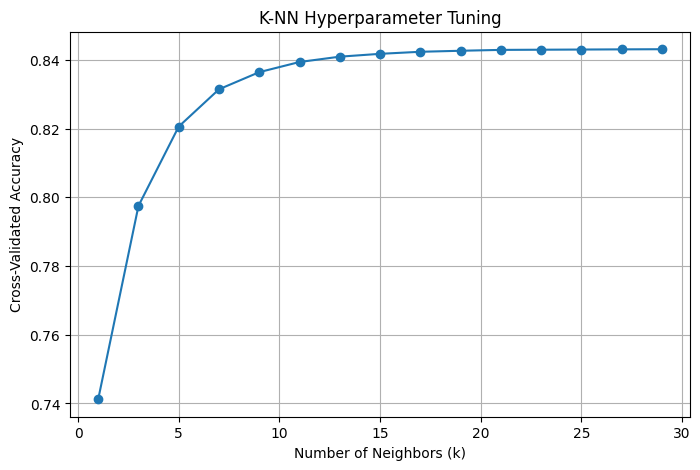

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cv_results = grid.cv_results_
k_values = cv_results['param_n_neighbors'].data
mean_accuracy = cv_results['mean_test_score']

plt.figure(figsize=(8,5))
plt.plot(k_values, mean_accuracy, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("K-NN Hyperparameter Tuning")
plt.grid(True)
plt.show()

In [ ]:
knn_final = KNeighborsClassifier(
    n_neighbors=best_k,
    metric='euclidean'
)
knn_final.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=29)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = knn_final.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8430974119585364
              precision    recall  f1-score   support

           0       0.12      0.00      0.00     11422
           1       0.84      1.00      0.91     61413

    accuracy                           0.84     72835
   macro avg       0.48      0.50      0.46     72835
weighted avg       0.73      0.84      0.77     72835



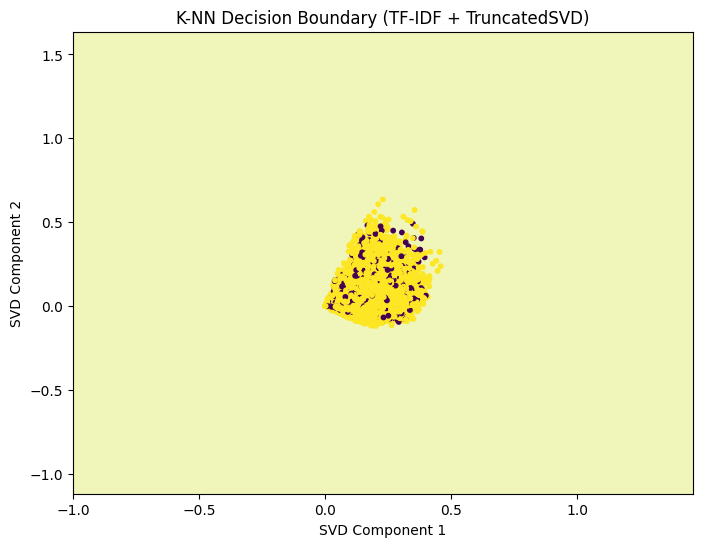

In [ ]:
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = knn_final.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y,
    s=10
)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("K-NN Decision Boundary (TF-IDF + TruncatedSVD)")
plt.show()

In [ ]:
test_review = [
    "This product is very good and tastes amazing"
]

test_tfidf = tf_idf_vect.transform(test_review)
test_2d = svd.transform(test_tfidf)

prediction = knn_final.predict(test_2d)
predicted_label = le.inverse_transform(prediction)

print("Predicted Sentiment:", predicted_label[0])


Predicted Sentiment: positive
